In [1]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt

df = pd.read_csv('our_sentences_probs_revised.csv')

df.head(2)


,sentence_pair,sentence1,sentence2,trial_type,subject,subject_selected_sentence,cluster,subjects_majority_vote_2clusters,subject_chose_majority_2clusters,agreement_2clusters,include_as_gpt_item,gpt_choice,gpt_engaged_subjects_agreement,probability_sentence1,probability_sentence2
0,A message has been sent to your account_They a...,A message has been sent to your account,They are barely able to handle Delhi properly,randomly_sampled_natural,2,1.0,engaged_struggling,1.0,1,1.0,True,1.0,1.0,-22.974632,-41.379541
1,Afterward my arm was ready to fall off_Half my...,Afterward my arm was ready to fall off,Half my heart was about to break open,synthetic_vs_synthetic,2,2.0,engaged_struggling,2.0,1,1.0,True,1.0,0.0,-34.901505,-30.706168


In [2]:
df['Model_sentence_selected'] = df.apply(lambda row: 1.0 if row['probability_sentence1'] > row['probability_sentence2'] else 2.0, axis=1)
df['Match'] = df.apply(lambda row: 'Y' if row['Model_sentence_selected'] == row['subjects_majority_vote_2clusters'] else 'N', axis=1)


In [3]:
# Filter rows where the match column is N to research
df_no_match = df[df['Match'] == 'N']
df_match = df[df['Match'] == 'Y']

df_no_match.head() # 243 out of 1485 rows (revised = 222) ??

,sentence_pair,sentence1,sentence2,trial_type,subject,subject_selected_sentence,cluster,subjects_majority_vote_2clusters,subject_chose_majority_2clusters,agreement_2clusters,include_as_gpt_item,gpt_choice,gpt_engaged_subjects_agreement,probability_sentence1,probability_sentence2,Model_sentence_selected,Match
10,Canyon looked really really bad in this game_Y...,Canyon looked really really bad in this game,You think your some kind of bright spark,randomly_sampled_natural,2,2.0,engaged_struggling,2.0,1,1.0,True,2.0,1.0,-34.962897,-40.238535,1.0,N
11,Commenting to find out later what this is_Memp...,Commenting to find out later what this is,Memphis always seems to play the Jazz tough,natural_controversial,2,1.0,engaged_struggling,1.0,1,1.0,True,2.0,0.0,-41.256103,-37.660084,2.0,N
16,Gets us in the playoffs next off year_Gets us ...,Gets us in the playoffs next off year,Gets us to the playoffs every following year,natural_vs_synthetic,2,1.0,engaged_struggling,1.0,1,1.0,True,1.0,1.0,-40.007630,-35.084132,2.0,N
19,Had her invite me over after the club_Please p...,Had her invite me over after the club,Please post in the Share Your Stuff thread,natural_controversial,2,1.0,engaged_struggling,1.0,1,1.0,True,2.0,0.0,-40.366589,-37.225466,2.0,N
20,Having crit done solves most of your problems_...,Having crit done solves most of your problems,Having used amp solves none of these problems,natural_vs_synthetic,2,2.0,engaged_struggling,2.0,1,1.0,True,2.0,1.0,-35.728356,-41.572726,1.0,N


In [4]:
df_no_match['wrong_sentence'] = df_no_match.apply(lambda row: row['sentence1'] if row['Model_sentence_selected'] == 1.0 else row['sentence2'], axis=1)
df_match['right_sentence'] = df_match.apply(lambda row: row['sentence1'] if row['Model_sentence_selected'] == 1.0 else row['sentence2'], axis=1)

wrong_sentences = df_no_match['wrong_sentence']
right_sentences = df_match['right_sentence']
wrong_sentences

/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


10         Canyon looked really really bad in this game
11          Memphis always seems to play the Jazz tough
16         Gets us to the playoffs every following year
19           Please post in the Share Your Stuff thread
20        Having crit done solves most of your problems
                             ...                       
3142    Their prices are pretty good compared to others
3191            You have never played Risk of Rain then
3192            You have never played Risk of Rain then
3193            You have never played Risk of Rain then
3194            You have never played Risk of Rain then
Name: wrong_sentence, Length: 515, dtype: object

## Load in transformer to interpret unmatched sentences

In [5]:
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Initialize tokenizer
# model_ckpt = "GPT-2"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Initialize tokenizer and set the padding token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  # or "gpt2-xl" for the larger model
tokenizer.pad_token = tokenizer.eos_token  # Set the end-of-text token as the padding token

# Modify the tokenize function to handle a list of dictionaries
def tokenize(batch):
    texts = [item["text"] for item in batch]  # Extract text from each dictionary
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")


In [6]:
from transformers import AutoModel
import torch

# model_ckpt = "WillHeld/roberta-base-sst2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = AutoModel.from_pretrained(model_ckpt).to(device)

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device) # change to gpt-xl when running for real

# Analysis methods

# 1. Parts of Speech (POS) Tagging

In [7]:
import spacy
import numpy as np
from collections import OrderedDict

#!python -m spacy download en_core_web_sm


# Load SpaCy's model
nlp = spacy.load("en_core_web_sm")

def calculate_mean_pos_counts(sentences):
    # Initialize a list to store the POS count dictionaries for each sentence
    pos_counts_list = []

    for sentence in sentences:
        # Analyze the sentence
        doc = nlp(sentence)
        # Initialize a dictionary to store POS counts for the current sentence
        pos_counts = {}

        for token in doc:
            pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1

        # Append the dictionary to the list
        pos_counts_list.append(pos_counts)

    # Convert the list of dictionaries into a dictionary of lists
    pos_counts_combined = {}
    for pos_count in pos_counts_list:
        for pos, count in pos_count.items():
            if pos in pos_counts_combined:
                pos_counts_combined[pos].append(count)
            else:
                pos_counts_combined[pos] = [count]

    # Calculate the mean POS count for each POS tag and round to 2 decimals
    mean_pos_counts = {pos: round(np.mean(counts), 2) for pos, counts in pos_counts_combined.items()}

    # Sort the dictionary by POS tag alphabetically
    mean_pos_counts_sorted = OrderedDict(sorted(mean_pos_counts.items()))

    return mean_pos_counts_sorted

# calculate means of POS lists based on sentences
mean_pos_counts_w = calculate_mean_pos_counts(wrong_sentences)
mean_pos_counts_r = calculate_mean_pos_counts(right_sentences)

print("Mean POS counts for wrong sentences:", mean_pos_counts_w)
print("Mean POS counts for right sentences:", mean_pos_counts_r)


Mean POS counts for wrong sentences: OrderedDict([('ADJ', 1.18), ('ADP', 1.25), ('ADV', 1.05), ('AUX', 1.18), ('CCONJ', 1.0), ('DET', 1.38), ('INTJ', 1.0), ('NOUN', 1.95), ('NUM', 1.0), ('PART', 1.2), ('PRON', 1.37), ('PROPN', 2.45), ('SCONJ', 1.03), ('VERB', 1.59)])
Mean POS counts for right sentences: OrderedDict([('ADJ', 1.32), ('ADP', 1.23), ('ADV', 1.17), ('AUX', 1.26), ('CCONJ', 1.03), ('DET', 1.21), ('INTJ', 1.03), ('NOUN', 1.85), ('NUM', 1.0), ('PART', 1.09), ('PRON', 1.5), ('PROPN', 1.28), ('SCONJ', 1.0), ('VERB', 1.57)])


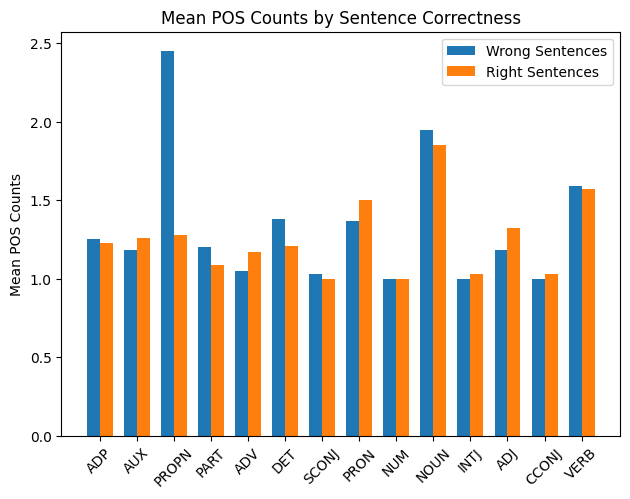

In [8]:
# Convert to lists for plotting
pos_tags = list(set(mean_pos_counts_w.keys()) | set(mean_pos_counts_r.keys()))
means_w = [mean_pos_counts_w.get(tag, 0) for tag in pos_tags]
means_r = [mean_pos_counts_r.get(tag, 0) for tag in pos_tags]

# Plotting
x = np.arange(len(pos_tags))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_w, width, label='Wrong Sentences')
rects2 = ax.bar(x + width/2, means_r, width, label='Right Sentences')

# Set up plot
ax.set_ylabel('Mean POS Counts')
ax.set_title('Mean POS Counts by Sentence Correctness')
ax.set_xticks(x)
ax.set_xticklabels(pos_tags)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

# 2. Sentiment Analysis


In [10]:
from transformers import pipeline

# Initialize the pipeline for emotion analysis with the specified BERT model

emotion_pipeline = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion")


# Convert all sentences to strings
wrong_sentences = [str(sentence) for sentence in wrong_sentences]
right_sentences = [str(sentence) for sentence in right_sentences]

# Function to analyze emotions and get distribution
def analyze_emotions(sentences):
    # Analyze emotion for each sentence
    emotions = emotion_pipeline(sentences)

    # Initialize a dictionary to hold the count of each emotion
    emotion_distribution = {}

    # Aggregate results
    for emotion in emotions:
        label = emotion['label']

        # Increment the count for the observed emotion
        emotion_distribution[label] = emotion_distribution.get(label, 0) + 1

    return emotion_distribution

# Analyze emotions for wrong and right sentences
emotion_distribution_w = analyze_emotions(wrong_sentences)
emotion_distribution_r = analyze_emotions(right_sentences)

print("Emotion distribution for wrong sentences:", emotion_distribution_w)
print("Emotion distribution for right sentences:", emotion_distribution_r)


Exception: Impossible to guess which tokenizer to use. Please provided a PretrainedTokenizer class or a path/identifier to a pretrained tokenizer.

In [ ]:
# Calculate the total count for wrong and right sentences
total_w = sum(emotion_distribution_w.values())
total_r = sum(emotion_distribution_r.values())

# Calculate the percentage of each emotion
emotion_percent_w = {emotion: (count / total_w) * 100 for emotion, count in emotion_distribution_w.items()}
emotion_percent_r = {emotion: (count / total_r) * 100 for emotion, count in emotion_distribution_r.items()}

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Emotion categories
emotions = list(set(emotion_percent_w.keys()) | set(emotion_percent_r.keys()))
emotions.sort()

# Data for plotting
width = 0.35
ind = range(len(emotions))

# Bars for wrong and right sentences
bars_w = [emotion_percent_w.get(emotion, 0) for emotion in emotions]
bars_r = [emotion_percent_r.get(emotion, 0) for emotion in emotions]

# Plot bars
rects1 = ax.bar(ind, bars_w, width, label='Wrong Sentences')
rects2 = ax.bar([p + width for p in ind], bars_r, width, label='Right Sentences')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.set_title('Emotion distribution by percentage')
ax.set_xticks([p + width / 2 for p in ind])
ax.set_xticklabels(emotions)
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Syntactic Dependency Parsing

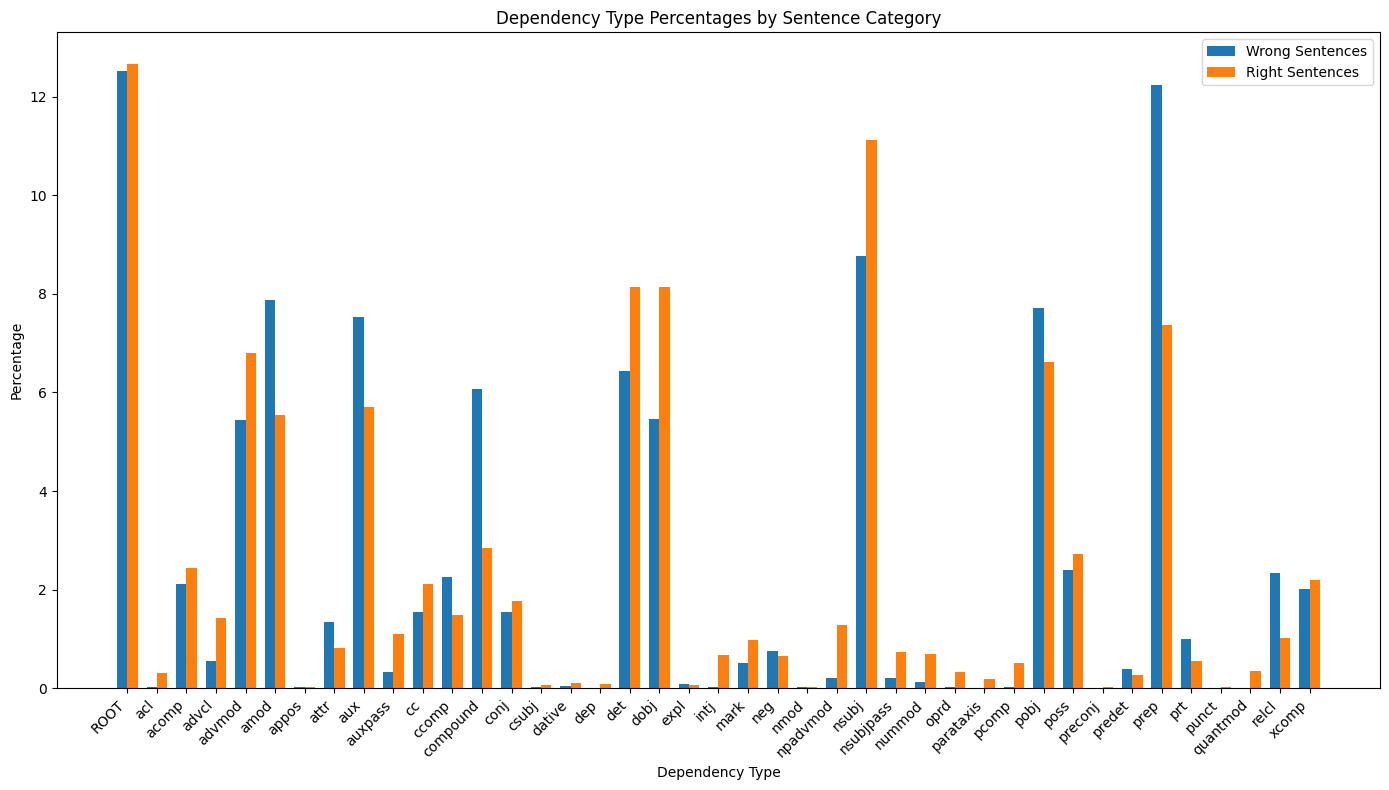

In [11]:
from collections import Counter, defaultdict

# Load SpaCy's model
nlp = spacy.load("en_core_web_sm")

def analyze_dependencies(sentences):
    """
    Analyzes the dependencies in sentences and returns a Counter object
    representing the frequency of each dependency type across all sentences.
    """
    dep_types = [token.dep_ for sentence in sentences for token in nlp(sentence)]
    return Counter(dep_types)

# Analyze both dependencies
dep_counters_wrong = analyze_dependencies(wrong_sentences)
dep_counters_right = analyze_dependencies(right_sentences)

### Step 2: Plot Dependency Frequencies for Comparison

def plot_dependency_comparison(dep_counter_wrong, dep_counter_right):
    """
    Plots the frequencies of dependency types for wrong vs. right sentences.
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Collect all unique dependencies in both groups
    all_deps = set(dep_counter_wrong.keys()).union(set(dep_counter_right.keys()))
    all_deps = sorted(list(all_deps))

    # Frequencies for plotting
    frequencies_wrong = np.array([dep_counter_wrong.get(dep, 0) for dep in all_deps])
    frequencies_right = np.array([dep_counter_right.get(dep, 0) for dep in all_deps])

    # Normalize frequencies to percentages
    frequencies_wrong = (frequencies_wrong / frequencies_wrong.sum()) * 100
    frequencies_right = (frequencies_right / frequencies_right.sum()) * 100

    # Plotting
    ind = np.arange(len(all_deps))
    width = 0.35

    rects1 = ax.bar(ind - width/2, frequencies_wrong, width, label='Wrong Sentences')
    rects2 = ax.bar(ind + width/2, frequencies_right, width, label='Right Sentences')

    ax.set_xlabel('Dependency Type')
    ax.set_ylabel('Percentage')
    ax.set_title('Dependency Type Percentages by Sentence Category')
    ax.set_xticks(ind)
    ax.set_xticklabels(all_deps, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Show final plot
plot_dependency_comparison(dep_counters_wrong, dep_counters_right)


# 4. Language Modeling & Perplexity

In [12]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load models
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define perplexity calculator
def calculate_perplexity(sentence):
    tokenize_input = tokenizer.encode(sentence, return_tensors="pt")
    loss = model(tokenize_input, labels=tokenize_input).loss
    return torch.exp(loss).item()


In [13]:
# Calculate perplexities for wrong sentences
perplexities_wrong = [calculate_perplexity(sentence) for sentence in wrong_sentences]

# Calculate perplexities for right sentences
perplexities_right = [calculate_perplexity(sentence) for sentence in right_sentences]

# Calculate relative weights to total
weights_wrong = np.ones_like(perplexities_wrong) / len(perplexities_wrong)
weights_right = np.ones_like(perplexities_right) / len(perplexities_right)


AttributeError: 'tuple' object has no attribute 'loss'

In [14]:
# Visualization
plt.figure(figsize=(10, 6))
plt.hist(perplexities_wrong, alpha=0.5, bins=30, weights=weights_wrong, label='Wrong Sentences', density=True)
plt.hist(perplexities_right, alpha=0.5, bins=30, weights=weights_right, label='Right Sentences', density=True)

plt.xlabel('Perplexity')
plt.ylabel('Density')
plt.title('Normalized Distribution of Perplexity Scores')
plt.legend()
plt.show()


NameError: name 'perplexities_wrong' is not defined

<Figure size 1000x600 with 0 Axes>

In [15]:
# Count the number of sentences with perplexity > 5000
num_high_perplexity_wrong = sum(p > 5000 for p in perplexities_wrong)
num_high_perplexity_right = sum(p > 5000 for p in perplexities_right)

# Calculate the percentages
percent_high_perplexity_wrong = (num_high_perplexity_wrong / len(perplexities_wrong)) * 100
percent_high_perplexity_right = (num_high_perplexity_right / len(perplexities_right)) * 100

print(f"Percentage of 'wrong' sentences with perplexity > 5000: {round(percent_high_perplexity_wrong, 2)}%")
print(f"Percentage of 'right' sentences with perplexity > 5000: {round(percent_high_perplexity_right, 2)}%")


NameError: name 'perplexities_wrong' is not defined

In [16]:
# Prepare data
data = [perplexities_wrong, perplexities_right]
labels = ['Wrong Sentences', 'Right Sentences']

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.ylabel('Perplexity')
plt.title('Comparison of Perplexity Distributions')
plt.grid(axis='y')
plt.show()


NameError: name 'perplexities_wrong' is not defined

# Comparison between delta perplexities sentence pairs

In [24]:
df.head(2)

,sentence_pair,sentence1,sentence2,trial_type,subject,subject_selected_sentence,cluster,subjects_majority_vote_2clusters,subject_chose_majority_2clusters,agreement_2clusters,include_as_gpt_item,gpt_choice,gpt_engaged_subjects_agreement,probability_sentence1,probability_sentence2,Model_sentence_selected,Match
0,A message has been sent to your account_They a...,A message has been sent to your account,They are barely able to handle Delhi properly,randomly_sampled_natural,2,1.0,engaged_struggling,1.0,1,1.0,True,1.0,1.0,-22.974632,-41.379541,1.0,Y
1,Afterward my arm was ready to fall off_Half my...,Afterward my arm was ready to fall off,Half my heart was about to break open,synthetic_vs_synthetic,2,2.0,engaged_struggling,2.0,1,1.0,True,1.0,0.0,-34.901505,-30.706168,2.0,Y


In [18]:
# Initialize the tokenizer and model again for safety
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define the perplexity calculation function againb
def calculate_perplexity(sentence):
    tokenize_input = tokenizer.encode(sentence, return_tensors="pt")
    with torch.no_grad():
        loss = model(tokenize_input, labels=tokenize_input).loss
    return torch.exp(loss).item()

# Convert sentences to string (if not already done before)
df['sentence1'] = df['sentence1'].astype(str)
df['sentence2'] = df['sentence2'].astype(str)

# Calculate perplexities for each sentence, storing it in columns
df['perplexity_sentence1'] = df['sentence1'].apply(calculate_perplexity)
df['perplexity_sentence2'] = df['sentence2'].apply(calculate_perplexity)

# Calculate absolute delta perplexity in a new column for distribution comparison
df['delta_perplexity'] = abs(df['perplexity_sentence1'] - df['perplexity_sentence2'])


AttributeError: 'tuple' object has no attribute 'loss'

In [ ]:
import seaborn as sns

# Filter the DataFrame for matches and non-matches
matches = df[df['Match'] == 'Y']['delta_perplexity']
non_matches = df[df['Match'] == 'N']['delta_perplexity']

# Plotting
plt.figure(figsize=(10, 6))
sns.kdeplot(matches, label='Matches (Y)', fill=True, common_norm=False, alpha=0.5)
sns.kdeplot(non_matches, label='Non-matches (N)', fill=True, common_norm=False, alpha=0.5)
plt.title('Density Plot of Delta Perplexities: Matches vs. Non-matches')
plt.xlabel('Delta Perplexity')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
# Mean delta perplexity for matches
mean_delta_perplexity_matches = df[df['Match'] == 'Y']['delta_perplexity'].mean()

# Mean delta perplexity for non-matches
mean_delta_perplexity_non_matches = df[df['Match'] == 'N']['delta_perplexity'].mean()

# Round to 2 dec
mean_delta_perplexity_matches_rounded = round(mean_delta_perplexity_matches, 2)
mean_delta_perplexity_non_matches_rounded = round(mean_delta_perplexity_non_matches, 2)

sentence = f"The mean delta perplexity for matches is {round(mean_delta_perplexity_matches, 2)}, and for non-matches, it is {round(mean_delta_perplexity_non_matches, 2)}."
print(sentence)


# Differences between Cosine similarities of sentence pair embeddings

In [19]:
# !pip install sentence-transformers

In [20]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to calculate cosine similarity
def calculate_cosine_similarity(embeddings1, embeddings2):

    # Cosine similarity between two sets of embeddings
    return cosine_similarity(embeddings1, embeddings2)[0][0]

# Generate embeddings
embeddings_sentence1 = model.encode(df['sentence1'].tolist())
embeddings_sentence2 = model.encode(df['sentence2'].tolist())

# Calculate cosine similarity for each pair of sentences
df['cosine_similarity'] = [calculate_cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
                           for embedding1, embedding2 in zip(embeddings_sentence1, embeddings_sentence2)]

ModuleNotFoundError: No module named 'sentence_transformers'

In [21]:
# Filter the DataFrame for matches and non-matches based on cosine_similarity
cosine_similarity_matches = df[df['Match'] == 'Y']['cosine_similarity']
cosine_similarity_non_matches = df[df['Match'] == 'N']['cosine_similarity']

# Plotting for Cosine Similarity
plt.subplot(2, 1, 2)
sns.kdeplot(cosine_similarity_matches, label='Matches (Y) - Cosine Similarity', fill=True, common_norm=False, alpha=0.5, color='green')
sns.kdeplot(cosine_similarity_non_matches, label='Non-matches (N) - Cosine Similarity', fill=True, common_norm=False, alpha=0.5, color='red')
plt.title('Density Plot of Cosine Similarities: Matches vs. Non-matches')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


KeyError: 'cosine_similarity'

In [22]:
# Mean cosine similarity for matches and non-matches
mean_cosine_similarity_matches = df[df['Match'] == 'Y']['cosine_similarity'].mean()
mean_cosine_similarity_non_matches = df[df['Match'] == 'N']['cosine_similarity'].mean()

# Round both to 2 dec
mean_cosine_similarity_matches_rounded = round(mean_cosine_similarity_matches, 2)
mean_cosine_similarity_non_matches_rounded = round(mean_cosine_similarity_non_matches, 2)

sentence_cosine = f"The mean cosine similarity for matches is {mean_cosine_similarity_matches_rounded}, and for non-matches, it is {mean_cosine_similarity_non_matches_rounded}."
print(sentence_cosine)


KeyError: 'cosine_similarity'